In [1]:
from imutils import paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/car-truck-dataset-sorted.zip .

In [ ]:
!unzip car-truck-dataset-sorted.zip

In [8]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

TRAINING_PATH = "/content/content/car-truck-dataset-sorted/training"
VALIDATION_PATH = "/content/content/car-truck-dataset-sorted/validation"
TESTING_PATH = "/content/content/car-truck-dataset-sorted/testing"
MODEL_NAME = "car-truck-classifier-resnet.model"

# Determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(TRAINING_PATH)))
totalVal = len(list(paths.list_images(VALIDATION_PATH)))
totalTest = len(list(paths.list_images(TESTING_PATH)))

In [9]:
# Initialize the training training data augmentation object
trainAug = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)
  
# Initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [10]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
  TRAINING_PATH,
  class_mode="categorical",
  color_mode="rgb",
  target_size=(128, 128),
  shuffle=True,
  seed=42,
  batch_size=BATCH_SIZE)
  
# Initialize the validation generator
valGen = valAug.flow_from_directory(
  VALIDATION_PATH,
  class_mode="categorical",
  color_mode="rgb",
  target_size=(128, 128),
  shuffle=False,
  seed=42,
  batch_size=BATCH_SIZE)
  
# Initialize the testing generator
testGen = valAug.flow_from_directory(
  TESTING_PATH,
  class_mode="categorical",
  color_mode="rgb",
  target_size=(128, 128),
  shuffle=False,
  batch_size=BATCH_SIZE)

Found 8134 images belonging to 2 classes.
Found 1016 images belonging to 2 classes.
Found 1018 images belonging to 2 classes.


(128, 128, 3)
(1, 128, 128, 3)


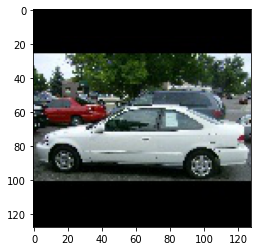

In [12]:
from keras.preprocessing import image
img = image.load_img("/content/content/car-truck-dataset-sorted/training/Car/00002.jpeg",target_size=(128,128))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [71]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
model = Sequential()
model.add(Conv2D(filters = 32, padding="same",activation = "relu",kernel_size=3, strides = 1,input_shape=(128,128,3)))
model.add(BatchNormalization(-1))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, padding="same",activation = "relu",kernel_size=3, strides = 3))
model.add(Dropout(0.2))
model.add(BatchNormalization(-1))

model.add(Conv2D(filters = 64, padding = "same",activation = "relu",kernel_size=3))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#Output layer
model.add(Dense(2,activation = "softmax"))

In [72]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_22 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 42, 42, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 42, 42, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_23 (Dropout)        (None, 14, 14, 64)       

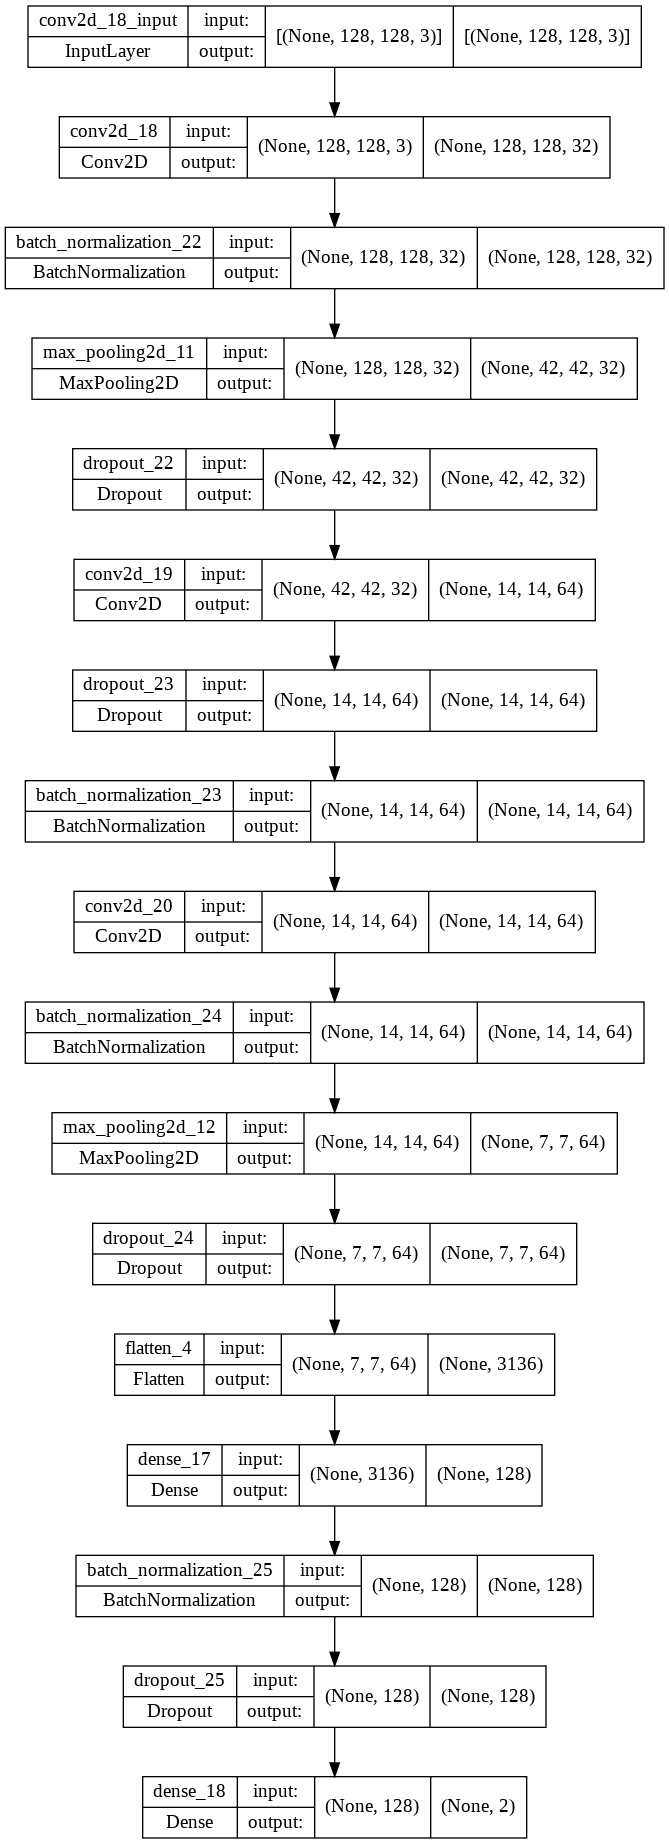

In [73]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [74]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [75]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [76]:
history=model.fit(trainGen,validation_data=valGen,epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/20
255/255 [==============================] - 34s 130ms/step - loss: 0.7785 - accuracy: 0.5743 - val_loss: 0.9472 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 2/20
255/255 [==============================] - 33s 129ms/step - loss: 0.6546 - accuracy: 0.6172 - val_loss: 0.7843 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 3/20
255/255 [==============================] - 33s 130ms/step - loss: 0.6224 - accuracy: 0.6512 - val_loss: 0.7337 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 4/20
255/255 [==============================] - 33s 129ms/step - loss: 0.5992 - accuracy: 0.6791 - val_loss: 0.9609 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 5/20
255/255 [==============================] - 33s 130ms/step - loss: 0.5817 - accuracy: 0.6928 - val_loss: 0.9448 - val_accuracy: 0.5915 - lr: 0.0010
Epoch 6/20
255/255 [==============================] - 33s 129ms/step - loss: 0.5609 - accuracy: 0.7085 - val_loss: 0.6311 - val_accuracy: 0.6772 - lr: 0.0010
Epoch 7/20
255/255 [==============================] 

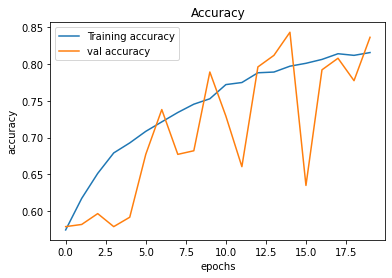

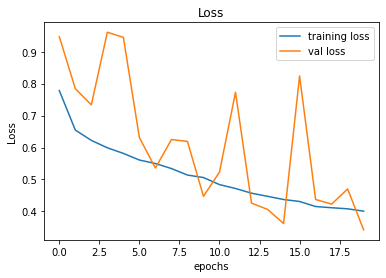

In [82]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [83]:
################# RESNET MODEL #################

In [92]:
base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3),include_top=False,weights="imagenet")

In [93]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten,GlobalAveragePooling2D

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(128,activation="relu"))

#Output layer
model.add(Dense(2,activation = "softmax"))

In [94]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_22 (Dense)            (None, 128)               262272    
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 2)                 258       
                                                      

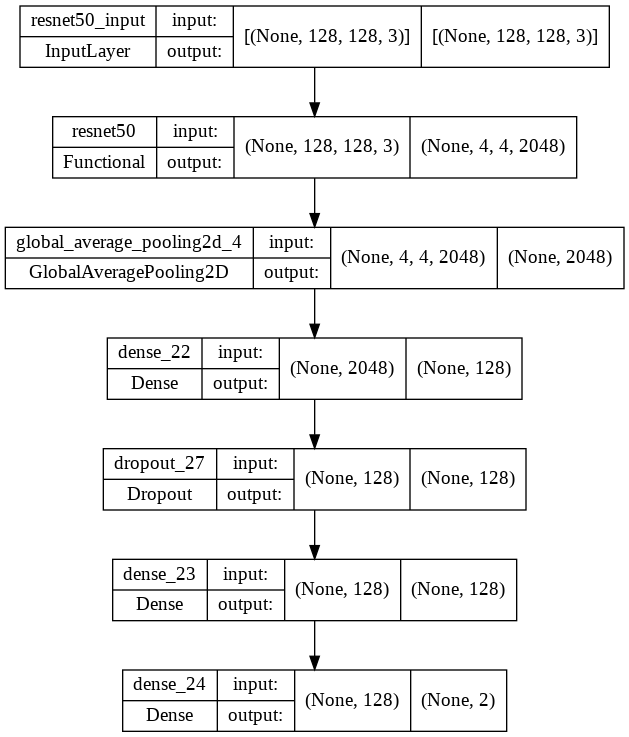

In [95]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [96]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [97]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [98]:
history=model.fit(trainGen,validation_data=valGen,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/10
255/255 [==============================] - 49s 167ms/step - loss: 0.5745 - accuracy: 0.7250 - val_loss: 2.5796 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 2/10
255/255 [==============================] - 42s 164ms/step - loss: 0.3781 - accuracy: 0.8405 - val_loss: 0.9213 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 3/10
255/255 [==============================] - 42s 163ms/step - loss: 0.3205 - accuracy: 0.8654 - val_loss: 0.8765 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 4/10
255/255 [==============================] - 42s 163ms/step - loss: 0.2689 - accuracy: 0.8853 - val_loss: 0.2633 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 5/10
255/255 [==============================] - 42s 164ms/step - loss: 0.2580 - accuracy: 0.8954 - val_loss: 0.3813 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 6/10
255/255 [==============================] - 42s 165ms/step - loss: 0.2282 - accuracy: 0.9077 - val_loss: 0.3073 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 7/10
255/255 [==============================] 

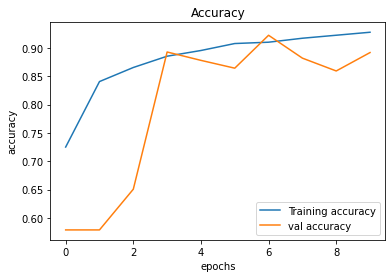

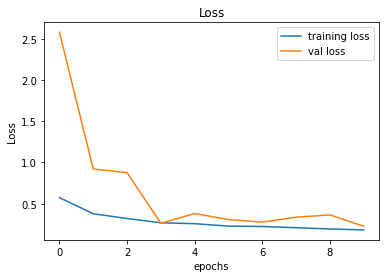

In [99]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()